# **Telco Churn Classification Project**

### By : Daniel Northcutt
### 11/29/21

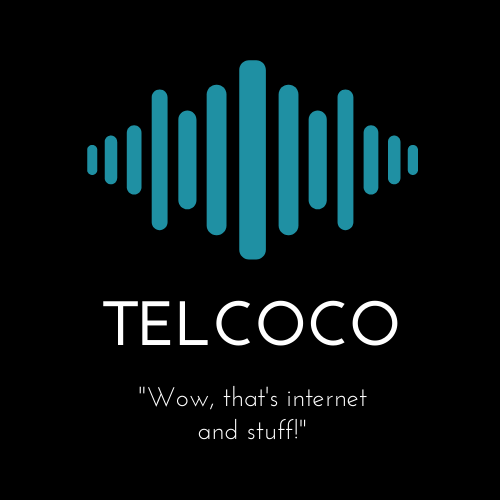

# Project Overview

### Utilize the DS pipeline and create a model that will predict whether a customer will churn based on drivers


# Project Goal

### Determine factors of churn and use models to perform better than the baseline

# EXECUTIVE SUMMARY

(To be completed)

# Adding Imports:

In [59]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



import graphviz
from graphviz import Graph

import acquire
import prepare
import user_defined_functions



# Acquire Data:

In [2]:
# This acquire function connects to the database, runs a SQL query, and returns the Telco churn into a useable dataframe

telco = acquire.get_telco_data()
df = telco
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [3]:
df.shape

(7043, 24)

# Acquire Takeaways

- Created an acquire function that connects to the database, runs a SQL query, and returns the Telco churn into
  a useable database, also saves file locally as a csv
  
  
- 7043 Rows = Customers
- 24 Columns = Features


<hr style="border:2px solid black"> </hr>


# Prepare Data: 

In [4]:
#preliminary clean delco:
def prep_telco(df):

    df = df.drop_duplicates()  #Drop duplicates
    
    #11 values are blank strings for total charges representing 11 customers at 0 tenure
    df['total_charges'] = df['total_charges'].str.strip() #eliminate white space
    df['total_charges'] = df['total_charges'].replace('', 0) #replace empty values as 0
    df['total_charges'] = df['total_charges'].astype('float64')

    #15 columns encoded to '0' = No, '1'= Yes
    #contract type MtM = 0, 1year = 1, 2year =2
    #concated manual billing = 0 , automatic billing = 1
    df['gender'] = df.gender.replace({'Female': 0, 'Male': 1})
    df['partner'] = df.partner.replace({'Yes': 1, 'No': 0})
    df['dependents'] = df.dependents.replace({'Yes': 1, 'No': 0})
    df['phone_service'] = df.phone_service.replace({'Yes': 1, 'No': 0})
    df['churn'] = df.churn.replace({'Yes': 1, 'No': 0})
    df['multiple_lines'] = df.multiple_lines.replace({'No': 0, "Yes": 1, "No phone service": 0})
    df['online_secuirty'] = df.online_security.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['online_backup'] = df.online_backup.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['device_protection'] = df.device_protection.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['tech_support'] = df.tech_support.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['streaming_tv'] = df.streaming_tv.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['streaming_movies'] = df.streaming_movies.replace({'No': 0, "Yes": 1, "No internet service": 0})
    df['paperless_billing'] = df.paperless_billing.replace({'Yes': 1, 'No': 0})
    #df['contract_type'] = df.contract_type.replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
    df['payment_type'] = df.payment_type.map({'Mailed check': 0, 'Credit card (automatic)': 1, 
                                               'Bank transfer (automatic)': 1,  'Electronic check': 0})


    # creating dummy values for payment, internet, & contract (*important values*)
    dummy_df = pd.get_dummies(df[["internet_service_type","contract_type"]])
    df = pd.concat([df, dummy_df], axis=1)

    #Rename columns
    columns_to_rename = {'contract_type': 'contract',
                    'internet_service_type': 'internet',
                    'gender': 'is_male',
                     'payment_type_id': 'payment_id',
                     'contract_type_id': 'contract_type',
                     'internet_service_type_DSL': 'DSL',
                     'internet_service_type_Fiber optic': 'fiber_optic',
                     'internet_service_type_None': 'no_internet',
                     'contract_type_Month-to-month': 'month_to_month',
                     'contract_type_One year': 'one_year_contract',
                     'contract_type_Two year': 'two_year_contract'}
    df = df.rename(columns = columns_to_rename)
    
    #dropping columns not need (#potentially update)
    columns_to_drop = {'customer_id', 'internet_service_type_id', 'internet', 'payment_id'}
    df = df.drop(columns=columns_to_drop)
    
    return df
    
####FUNCTION NOTES:
#drop internet, internet_service_type_id, payment_id

In [5]:
df = prep_telco(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   contract_type      7043 non-null   int64  
 1   is_male            7043 non-null   int64  
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   int64  
 4   dependents         7043 non-null   int64  
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   int64  
 7   multiple_lines     7043 non-null   int64  
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   int64  
 10  device_protection  7043 non-null   int64  
 11  tech_support       7043 non-null   int64  
 12  streaming_tv       7043 non-null   int64  
 13  streaming_movies   7043 non-null   int64  
 14  paperless_billing  7043 non-null   int64  
 15  monthly_charges    7043 non-null   float64
 16  total_charges      7043 

In [7]:
df.head()

,contract_type,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,churn,contract,payment_type,online_secuirty,DSL,fiber_optic,no_internet,month_to_month,one_year_contract,two_year_contract
0,3,0,0,1,1,65,1,1,Yes,1,...,0,Two year,0,1,1,0,0,0,0,1
1,3,1,0,0,0,54,0,0,Yes,0,...,0,Two year,1,1,1,0,0,0,0,1
2,3,0,0,0,0,56,0,0,Yes,1,...,0,Two year,1,1,1,0,0,0,0,1
3,3,1,0,1,1,20,0,0,Yes,0,...,0,Two year,1,1,1,0,0,0,0,1
4,3,1,0,1,0,72,1,1,No,1,...,0,Two year,1,0,1,0,0,0,0,1


In [8]:
def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)
    return train, validate, test

In [9]:
train, validate, test = split_telco_data(df)

In [10]:
print(f' train shape = {train.shape}')
print(f' validate shape = {validate.shape}')
print(f' test shape = {test.shape}')

 train shape = (3943, 27)
 validate shape = (1691, 27)
 test shape = (1409, 27)


# Prepare Takeaways:

#### Prepare function:
- Drop duplicated values
- 'total_charges' eliminated whitespace, replaced empty values, changed to float
- Encoded 15 columns to '0' = No, '1' = Yes
- Concated billing to manual payments ('0') and automatic payments ('1')
- Renamed columns 
- Dummy variables for internet service type and contract type
- Dropped columns - remaining 27


#### Split function:
- Split our data into a train, validate, and test datasets

<hr style="border:2px solid black"> </hr>


# Exploring Our Data:

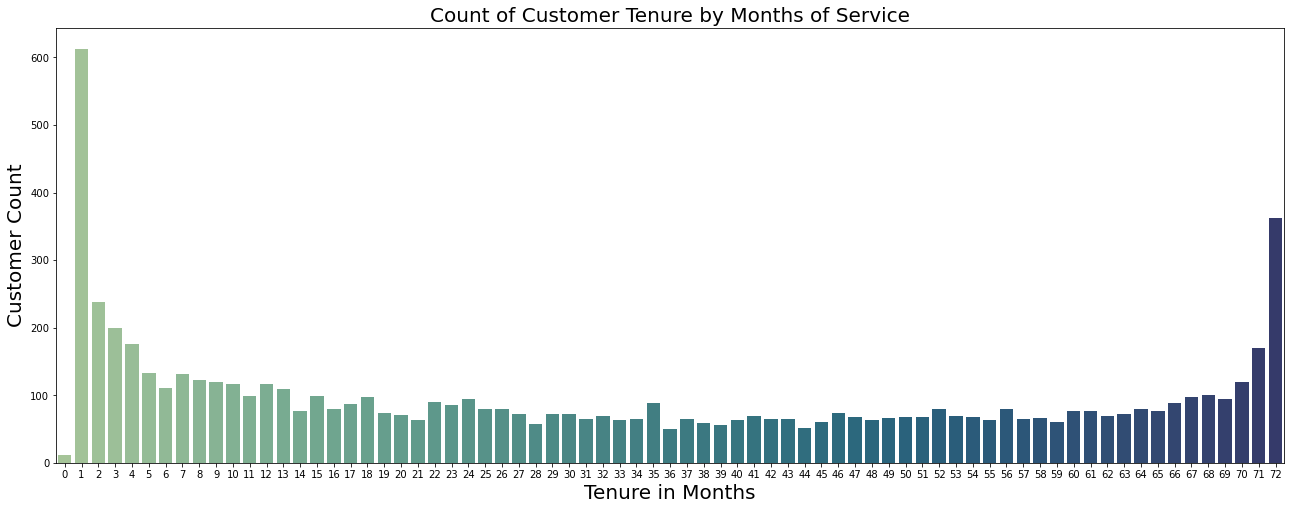

In [11]:
# Showing customer count by tenure

# Shows that customer churn is extremely high the first 6 months 

plt.figure(figsize = (22, 8))
sns.countplot(df.tenure, palette=("crest"))
plt.title('Count of Customer Tenure by Months of Service', fontsize= 20)
plt.xlabel('Tenure in Months', fontsize= 20)
plt.xticks(fontsize = 10)
plt.ylabel('Customer Count', fontsize = 20)
# plt.axhline(y= 32, linestyle= '--')
plt.show()

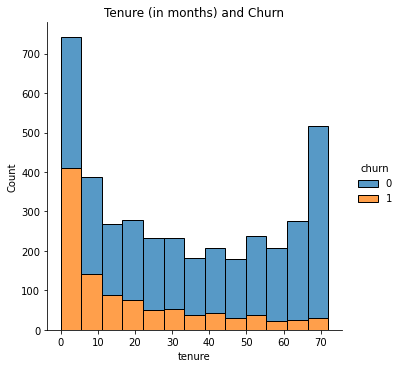

In [12]:
# This chart shows that churn is primarily coming from our month to month customers
# who continually represent a smaller portion of continued customers

sns.displot(train, x="tenure",hue="churn", multiple='stack')
plt.title('Tenure (in months) and Churn')
plt.show();


### Our goal is to find the services that are causing this churn while maintaining our MtM service

In [13]:
# Here we created a correlation of all features to churn

traincorr = train.corr()
traincorr = traincorr.sort_values(by='churn', ascending=False)
pd.DataFrame(traincorr.churn)

,churn
churn,1.000000
month_to_month,0.409166
fiber_optic,0.303591
monthly_charges,0.189040
paperless_billing,0.187409
senior_citizen,0.165482
streaming_tv,0.069691
streaming_movies,0.062017
multiple_lines,0.041917
phone_service,0.011995


Text(0.5, 1.0, 'Customer features associated with Churn')

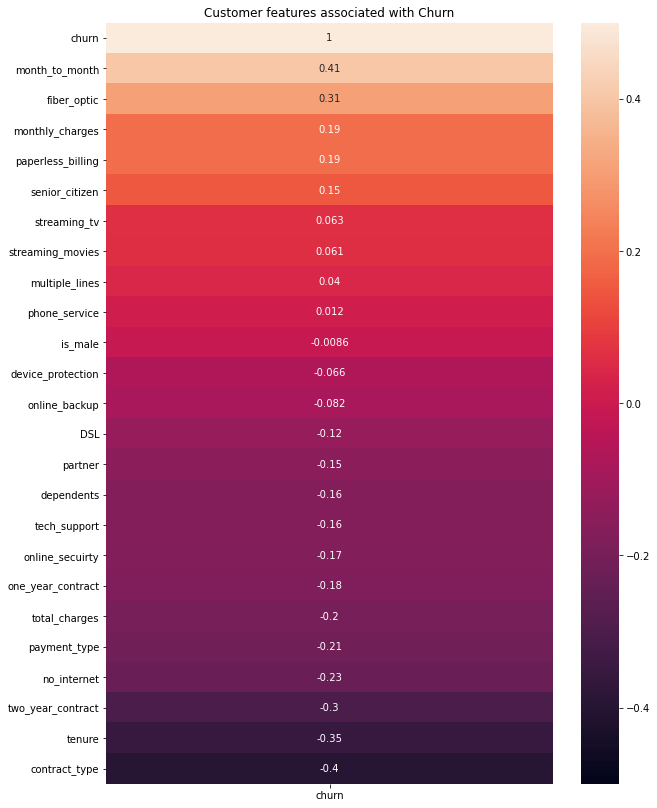

In [14]:
# We represented this correlation in columns by this heatmap to give us a physical representation

plt.figure(figsize = (10,14))
sns.heatmap(df.corr()[['churn']].sort_values(by='churn', ascending = False),vmin=-.5, vmax=.5, annot=True)
plt.title('Customer features associated with Churn')

### Here we can assume that fiber optic has a greater churn than DSL and that manual forms of payments has a greater churn than automatic



<hr style="border:2px solid black"> </hr>


## Let's look at the relationship of DSL and Fiber

In [15]:
#3096 customers have fiber optic

df.fiber_optic.value_counts()

0    3947
1    3096
Name: fiber_optic, dtype: int64

In [16]:
#understanding the costs of fiber optics

df.groupby('fiber_optic').monthly_charges.agg(['min', 'mean', 'max'])

,min,mean,max
fiber_optic,,,
0,18.25,43.788244,94.80
1,67.75,91.500129,118.75


In [17]:
# Understanding the costs of DSL
# Shows that DSL is significantly cheaper than Fiber
df.groupby('DSL').monthly_charges.agg(['min', 'mean', 'max'])

,min,mean,max
DSL,,,
0,18.25,68.249946,118.75
1,23.45,58.102169,94.80


In [18]:
churned = df[df['churn'] == 1].tenure
dsl = df[df['DSL'] == 1]
fiber = df[df['fiber_optic'] == 1]

In [19]:
# Observing Fiber's churn rate
observed = pd.crosstab(df.fiber_optic, df.churn)
observed

churn,0,1
fiber_optic,,
0,3375,572
1,1799,1297


In [20]:
# Observing DSL churn rate
# Shows to be significantly lower than Fiber
observed = pd.crosstab(df.DSL, df.churn)
observed

churn,0,1
DSL,,
0,3212,1410
1,1962,459


## From these values we learn that DSL offers a lower price point than Fiber and has less churn than Fiber

<hr style="border:2px solid black"> </hr>

# Hypothesis Testing:

## Let's see the relationship of DSL and Fiber to churn



## Hypothesis 1: Determine if there is a relationship between DSL and churn

- Alpha = .05

- $H_0$ : There is no relationship between DSL service and churn

- $H_a$ : There is a relationship between DSL service and churn

In [21]:
observed = pd.crosstab(train.churn, train.DSL)
observed

DSL,0,1
churn,,
0,1791,1106
1,787,259


In [22]:
# Categorical use Chi2
alpha = .5
chi2, p, degf, expected = stats.chi2_contingency(observed)


print('Observed\n')
print(observed)
print('---------------------\nExpected\n')
print(expected.astype(int))
print('---------------------\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('''\n Our p value is less than our alpha and we can reject the null hypothesis
         There is a relationship between payment type and churn.''')
else:
    print('We cannot reject the null hypothesis')

Observed

DSL       0     1
churn            
0      1791  1106
1       787   259
---------------------
Expected

[[1894 1002]
 [ 683  362]]
---------------------

chi^2 = 60.5262
p     = 0.0000

 Our p value is less than our alpha and we can reject the null hypothesis
         There is a relationship between payment type and churn.


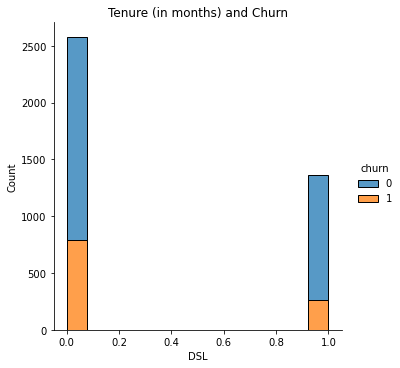

In [23]:
sns.displot(train, x="DSL",hue="churn", multiple='stack')
plt.title('Tenure (in months) and Churn')
plt.show();



## Hypothesis 2: Determine if there is a relationship between Fiber Optic and churn

- Alpha = .05

- $H_0$ : There is no relationship between fiber optic service and churn

- $H_a$ : There is a relationship between fiber optic service and churn

In [24]:
observed = pd.crosstab(train.churn, train.fiber_optic)
observed

fiber_optic,0,1
churn,,
0,1881,1016
1,322,724


In [25]:
# Categorical use Chi2
alpha = .5
chi2, p, degf, expected = stats.chi2_contingency(observed)


print('Observed\n')
print(observed)
print('---------------------\nExpected\n')
print(expected.astype(int))
print('---------------------\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('''\n Our p value is less than our alpha and we can reject the null hypothesis
         There is a relationship between payment type and churn.''')
else:
    print('We cannot reject the null hypothesis')

Observed

fiber_optic     0     1
churn                  
0            1881  1016
1             322   724
---------------------
Expected

[[1618 1278]
 [ 584  461]]
---------------------

chi^2 = 362.0332
p     = 0.0000

 Our p value is less than our alpha and we can reject the null hypothesis
         There is a relationship between payment type and churn.


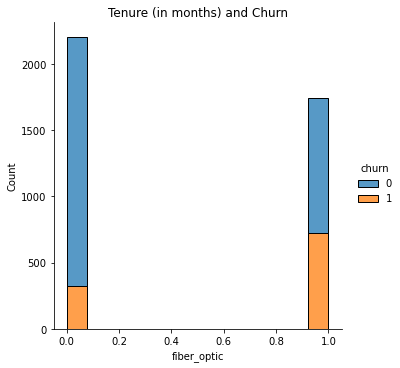

In [26]:
sns.displot(train, x="fiber_optic",hue="churn", multiple='stack')
plt.title('Tenure (in months) and Churn')
plt.show();

## Takeaways:
- Both DSL and fiber optic tested to have a relationship with churn
- Through data discovery we learned DSL has a lower churn rate and lower cost to customers
- Fiber opitc should be a continued focus point in understanding churn

<hr style="border:2px solid black"> </hr>


## Hypothesis 3: Determine if there is a relationship between payment type and churn

Alpha = .05

𝐻0  : There is no relationship between payment type and churn

𝐻𝑎  : There is a relationship between payment type and churn

In [27]:
#3977 represent manual payments
#3066 represent automatic payments

df.payment_type.value_counts()

0    3977
1    3066
Name: payment_type, dtype: int64

In [28]:
observed = pd.crosstab(train.churn, train.payment_type)
observed

payment_type,0,1
churn,,
0,1450,1447
1,762,284


In [29]:
# Categorical use Chi2
alpha = .5
chi2, p, degf, expected = stats.chi2_contingency(observed)


print('Observed\n')
print(observed)
print('---------------------\nExpected\n')
print(expected.astype(int))
print('---------------------\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('''\n Our p value is less than our alpha and we can reject the null hypothesis
         There is a relationship between payment type and churn.''')
else:
    print('We cannot reject the null hypothesis')

Observed

payment_type     0     1
churn                   
0             1450  1447
1              762   284
---------------------
Expected

[[1625 1271]
 [ 586  459]]
---------------------

chi^2 = 161.2517
p     = 0.0000

 Our p value is less than our alpha and we can reject the null hypothesis
         There is a relationship between payment type and churn.


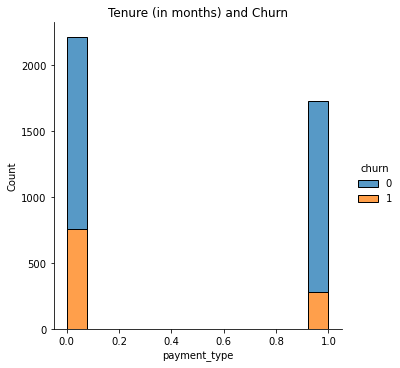

In [30]:
sns.displot(train, x="payment_type",hue="churn", multiple='stack')
plt.title('Tenure (in months) and Churn')
plt.show();

## Takeaways:

- 

<hr style="border:2px solid black"> </hr>


# Model and Evaluate:

In [31]:
# First let us get our baseline prediction
train.churn.value_counts()

0    2897
1    1046
Name: churn, dtype: int64

In [32]:
#Determine that the majority will be our baseline
train['baseline_prediction'] = 0

baseline_accuracy = (train.churn == train.baseline_prediction).mean()
print(f'The baseline accuracy is: {baseline_accuracy:.2%}')

The baseline accuracy is: 73.47%


In [33]:
#Determining the features we want to make predictions from

X_column = ['payment_type', 'month_to_month', 'partner', 'dependents', 'senior_citizen']
y_column = 'churn'

In [34]:
# Specifying our train, validate, and test for our models

X_train = train[X_column]
y_train= train[y_column]

X_validate = validate[X_column]
y_validate= validate[y_column]

X_test = test[X_column]
y_test= test[y_column]


## Decision Tree:

In [35]:
#created and fitted the model
tree_time = DecisionTreeClassifier(max_depth=10, random_state=123)
tree_time = tree_time.fit(X_train, y_train)
tree_time_pred = tree_time.predict(X_train)

In [36]:
#defined our parameters for precision and recall
TP = confusion_matrix(y_train, tree_time_pred)[0][0]
FP = confusion_matrix(y_train, tree_time_pred)[0][1]
FN = confusion_matrix(y_train, tree_time_pred)[1][0]
precision = TP/(TP+FP)
recall = TP/(TP+FN)

In [37]:
print(f'training score: {tree_time.score(X_train, y_train):.2%}\n')
print(f'validate score: {tree_time.score(X_validate, y_validate):.2%}\n')
#print('The difference from Baseline: {:.2f}%'.format(d))
print(f'The baseline accuracy is: {baseline_accuracy:.2%}\n')

print(f'The precision is: {precision:.2%}')
print(f'The recall is: {recall:.2%}')


training score: 75.04%

validate score: 74.57%

The baseline accuracy is: 73.47%

The precision is: 95.79%
The recall is: 76.30%


### Decision Tree Takeaways:

- Both our training score and validate score performed better than our baseline
- Precision at 95.8% & recall at 76.3%

<hr style="border:2px solid black"> </hr>

# Random Forest:

In [38]:
# Create and fit the model
forest_time = RandomForestClassifier(min_samples_leaf = 1, max_depth = 12, random_state= 123)
forest_time.fit(X_train, y_train)
forest_time_pred = forest_time.predict(X_train)

In [39]:
#defined our parameters for precision and recall
TP = confusion_matrix(y_train, forest_time_pred)[0][0]
FP = confusion_matrix(y_train, forest_time_pred)[0][1]
FN = confusion_matrix(y_train, forest_time_pred)[1][0]
precision = TP/(TP+FP)
recall = TP/(TP+FN)

In [40]:
print(f'training score: {forest_time.score(X_train, y_train):.2%}\n')
print(f'validate score: {forest_time.score(X_validate, y_validate):.2%}\n')
#print('The difference from Baseline: {:.2f}%'.format(d))
print(f'The baseline accuracy is: {baseline_accuracy:.2%}\n')

print(f'The precision is: {precision:.2%}')
print(f'The recall is: {recall:.2%}')


training score: 75.04%

validate score: 73.98%

The baseline accuracy is: 73.47%

The precision is: 94.62%
The recall is: 76.80%


### Random Forest Takeaways:

- Both our training score and validate score performed better than our baseline
- Precision at 94.6% & recall at 76.8%

<hr style="border:2px solid black"> </hr>


# Logistic Regression:

- Lets compare the same features but replace payment_type (automatic and manual) with DSL and Fiber Optic

- Let's see if our models are able to predict churn better using DSL or Fiber Optic

In [41]:
#Create a function

# Separate out our X and y values
X_train = train.drop(columns=['churn'])
y_train = train[['churn']]

X_validate = validate.drop(columns=['churn'])
y_validate = validate[['churn']]

X_test = test.drop(columns=['churn'])
y_test = test[['churn']]

In [47]:
#creating the logistic regression 
lr_model1 = LogisticRegression(random_state=123)

# features
features = ['DSL', 'month_to_month', 'partner', 'dependents', 'senior_citizen']

#fitting
lr_model1.fit(X_train[features], y_train)

lr_predictions  = lr_model1.predict(X_train[features])
DSL_pred = lr_model.score(X_train[features], y_train)

print("Logistic Regression using", features)
print(f'\n The baseline accuracy is: {baseline_accuracy:.2%}\n')
print(f' The Accuracy of Logistic Regression on the DSL training set is: {DSL_pred:.2%}')



Logistic Regression using ['DSL', 'month_to_month', 'partner', 'dependents', 'senior_citizen']

 The baseline accuracy is: 73.47%

 The Accuracy of Logistic Regression on the DSL training set is: 70.15%


In [53]:
#creating the logistic regression 
lr_model2 = LogisticRegression(random_state=123)

# features
features = ['fiber_optic', 'month_to_month', 'partner', 'dependents', 'senior_citizen']

#fitting
lr_model2.fit(X_train[features], y_train)

lr_predictions  = lr_model2.predict(X_train[features])
fiber_pred = lr_model.score(X_train[features], y_train)

print("Logistic Regression using", features)
print(f'\n The baseline accuracy is: {baseline_accuracy:.2%}\n')
print(f' The Accuracy of Logistic Regression on the Fiber Optic training set is: {fiber_pred:.2%}')

Logistic Regression using ['fiber_optic', 'month_to_month', 'partner', 'dependents', 'senior_citizen']

 The baseline accuracy is: 73.47%

 The Accuracy of Logistic Regression on the Fiber Optic training set is: 76.29%


## Logistic Regression Takeaways:

- Both models performed better than our baseline
- Fiber proved to be a better feature than DSL for our model
- We can assume that due to a higher ratio of fiber customers churning we are able to run a better model for churn

<hr style="border:2px solid black"> </hr>


# THE TEST!

In [61]:
lr_model2.fit(X_test[features], y_test)
fiber_test = lr_model.score(X_test[features], y_test)

#print("Logistic Regression using", features)
print(f'\n The baseline accuracy is: {baseline_accuracy:.2%}\n')
print(f' The Accuracy of Logistic Regression on the Fiber Optic test set is:\n {fiber_test:.2%}')


 The baseline accuracy is: 73.47%

 The Accuracy of Logistic Regression on the Fiber Optic test set is:
 76.65%


### We ran our final model based on what preformed best of our testing set.  Our logistic regression model based under fiber was the ideal candidate and performed very slightly better then the test at 76.65% accuracy

<hr style="border:2px solid black"> </hr>


# Conclusions:

- Our data exploration helped us gain a greater understanding of drivers of churn
- We highlighted the relationship between tenure & churn further diving into DSL vs fiber options and manual vs automatic payments.


- All four models tested above the baseline
- All three chi^2 tests rejected the null hypothesis


- Through our data we can provide a model giving a 76.65% accuracy for predicting churn and offered feature groups of customers that we can specifically target to help better reduce churn

<hr style="border:2px solid black"> </hr>


# Recommendations:

- Offer incentives to switch customers from automatic payments to manual

- Target internet seeking customers to DSL rather than fiber in aiding against attrition



# 50%, 30%, and 20%,

50%, 26%, 24%

In [50]:
# final_test = y_test
# best_predicted = lr_model.predict(X_test)
print(final_test, lr_model2.predict(X_test))

ValueError: could not convert string to float: 'Yes'

In [46]:
actual_test = y_test
predicted_test = tree_time.predict(X_test)
print(classification_report(actual_test, predicted_test))

ValueError: could not convert string to float: 'Yes'

In [ ]:
#creating the logistic regression 
lr_model = LogisticRegression(random_state=123)

# features
features = ['DSL', 'month_to_month', 'partner', 'dependents']

lr_model.fit(X_train[features], y_train)

lr_predictions  = lr_model.predict(X_train[features])

print("Logistic Regression using", features)
print(f'\n The baseline accuracy is: {baseline_accuracy:.2%}')

print('\n Accuracy of Logistic Regression classifier on training set: {:.2f}'.
     format(lr_model.score(X_train[features], y_train)))

In [ ]:
TP = confusion_matrix(y_train, random_forest_predictions)[0][0]
FP = confusion_matrix(y_train, random_forest_predictions)[0][1]
FN = confusion_matrix(y_train, random_forest_predictions)[1][0]
precision = TP/(TP+FP)
recall = TP/(TP+FN)

print(precision)

In [ ]:
# Making things easy to read:
print('Accuracy of Datasets on Random Forest Model:\nRandom Forest on Training: {:.2f}%'
      .format((random_forest_model.score(X_train, y_train)*100)))
print('Random Forest on Validate: {:.2f}%'
      .format((random_forest_model.score(X_validate, y_validate)*100)))
print('Percent Difference from Baseline: {:.2f}%'
      .format((random_forest_model.score(X_train, y_train) - baseline_accuracy)*100))
print("\nRandom Forest Recall:", round(recall*100, 2) , "%")
print("Random Forest Precision:", round(precision*100, 2) , "%")

In [ ]:
X_train = train.drop(columns=["churn"])
y_train = train.churn

X_validate = validate.drop(columns=["churn"])
y_validate = validate.churn

X_test = test.drop(columns=["churn"])
y_test = test.churn


In [ ]:
# X_test = test.drop(columns = ['churn'])
# y_test = test.churn

In [ ]:
X_train, y_train = train[X_cols], train[y_col]
X_validate, y_validate = validate[X_cols], validate[y_col]
X_test, y_test = test[X_cols], test[y_col]
    
X_train, y_train, X_validate, y_validate, X_test, y_test

In [ ]:
#Create a function

# Separate out our X and y values
X_train = train.drop(columns=['churn'])
y_train = train[['churn']]

X_validate = validate.drop(columns=['churn'])
y_validate = validate[['churn']]

X_test = test.drop(columns=['churn'])
y_test = test[['churn']]

In [ ]:
train.columns

In [ ]:
train.DSL

In [ ]:
#creating the logistic regression 
lr_model = LogisticRegression(random_state=123)

# features
features = ['DSL','month_to_month', 'partner', 'dependents']

lr_model.fit(X_train[features], y_train)

lr_predictions  = lr_model.predict(X_train[features])

print("Logistic Regression using", features)
print(f'\n The baseline accuracy is: {baseline_accuracy:.2%}')

print('\n Accuracy of Logistic Regression classifier on training set: {:.2f}'.
     format(lr_model.score(X_train[features], y_train)))

#print(f'training score: {logit.score(X_train, y_train):.2%}')
#print(f'validate score: {logit.score(X_validate, y_validate):.2%}')

In [ ]:
#creating the logistic regression 
lr_model = LogisticRegression(random_state=123)

# features
features = ['fiber_optic', 'month_to_month', 'partner', 'dependents']

lr_model.fit(X_train[features], y_train)

lr_predictions  = lr_model.predict(X_train[features])

print("Logistic Regression using", features)
print(f'\n The baseline accuracy is: {baseline_accuracy:.2%}')
print('\n Accuracy of Logistic Regression classifier on training set: {:.2f}'.
     format(lr_model.score(X_train[features], y_train)))

In [ ]:
plt.figure(figsize = (22, 8))
sns.countplot(df.tenure.groupby(manual_payment), palette=("crest"))
plt.title('Customer Tenure by Months of Service', fontsize= 20)
plt.xlabel('Tenure in Months', fontsize= 20)
plt.xticks(fontsize = 10)
plt.ylabel('Customer Count', fontsize = 20)
plt.show()

In [ ]:
def num_distributions(df):
    '''
    pulled from Faith Kane's notebook
    This functions takes in a dataframe and displays
    the distribution of each numeric column.
    '''
    for col in df.columns:
        if df[col].dtype != 'object':
            plt.hist(df[col])
            plt.title(f'Distribution of {col}')
            plt.show()

In [ ]:
num_distributions(df)

# DSL VS FIBER

In [ ]:
df.DSL.value_counts()

In [ ]:
df.fiber_optic.value_counts()

In [ ]:
df.groupby('fiber_optic').monthly_charges.agg(['min', 'mean', 'max'])

In [ ]:
df.groupby('fiber_optic').monthly_charges.agg(['min', 'mean', 'max'])

In [ ]:
df.groupby('DSL').monthly_charges.agg(['min', 'mean', 'max'])

In [ ]:
churned = df[df['churn'] == 1].tenure
dsl = df[df['DSL'] == 1]
fiber = df[df['fiber_optic'] == 1]

In [ ]:
dsl = df[df['DSL'] == 1]

In [ ]:
fiber = df[df['fiber_optic'] == 1]

In [ ]:
observed = pd.crosstab(mpg.drv, mpg.transmission)
observed

In [ ]:
observed = pd.crosstab(df.DSL, df.churn)
observed

In [ ]:
observed = pd.crosstab(df.fiber_optic, df.churn)
observed

# Churn

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='churn', data=train, palette='inferno_r')
plt.show()

In [ ]:
telco_correlation = train.corr['churn']
telco_correlation

ValueError: 'Set4' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [ ]:
categ = df.nunique()[df.nunique() <= 5].index
list(categ)

In [ ]:
cat_vars = ['contract_type',
 'is_male',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract',
 'payment_type',
 'online_secuirty',
 'payment_type',
 'DSL',
 'fiber_optic',
 'no_internet',
 'month_to_month',
 'one_year_contract',
 'two_year_contract']

quant_vars = ['total_charges', 'tenure', 'monthly_charges']

In [ ]:
df.drop_duplicates()

In [ ]:
user_defined_functions.explore_univariate(df, cat_vars, quant_vars)

In [ ]:
x = sns.barplot(x="DSL", y="churn", data=df, color="blue")
x.set(xlabel="Had DSL", ylabel = "Churn")
plt.show()

## Hypothesis 2: Determine if there is a relationship between payment type and churn

- Alpha = .05

- $H_0$ : There is no relationship between payment type and churn

- $H_a$ : There is a relationship between payment type and churn

In [ ]:
df.payment_type.value_counts()

In [ ]:
observed = pd.crosstab(train.churn, train.payment_type)
observed

In [ ]:
# Categorical use Chi2
alpha = .5
chi2, p, degf, expected = stats.chi2_contingency(observed)


print('Observed\n')
print(observed)
print('---------------------\nExpected\n')
print(expected.astype(int))
print('---------------------\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('''\n Our p value is less than our alpha and we can reject the null hypothesis
         There is a relationship between payment type and churn.''')
else:
    print('We cannot reject the null hypothesis')

In [ ]:
sns.pairplot(df[[ 'DSL', 'fiber_optic', 'churn']], hue='churn')
plt.show()

In [ ]:
sns.pairplot(df[['tenure', 'monthly_charges', 'total_charges', 'churn']], hue='churn')
plt.show()

In [ ]:
#bar plots to show rate of churn within each category
#statistical test - category & category = chi^2
    #if finidng a significant difference then include it in the modeling phase

## Sample questions

### Are customers with DSL more or less likely to churn?
### What month are customers most likely to churn and does that depend on their contract type?
### Is there a service that is associated with more churn than expected?
### Do customers who churn have a higher average monthly spend than those who don't?

In [ ]:
###### PRIMARY FUNCTION!!!!

In [ ]:
# #preliminary clean delco:
# def prep_telco(df):

#     df = df.drop_duplicates()  #Drop duplicates
    
#     #11 values are blank strings for total charges representing 11 customers at 0 tenure
#     df['total_charges'] = df['total_charges'].str.strip() #eliminate white space
#     df['total_charges'] = df['total_charges'].replace('', 0) #replace empty values as 0
#     df['total_charges'] = df['total_charges'].astype('float64')

#     #15 columns encoded to '0' = No, '1'= Yes
#     #contract type MtM = 0, 1year = 1, 2year =2
#     #concated manual billing = 0 , automatic billing = 1
#     df['gender'] = df.gender.replace({'Female': 0, 'Male': 1})
#     df['partner'] = df.partner.replace({'Yes': 1, 'No': 0})
#     df['dependents'] = df.dependents.replace({'Yes': 1, 'No': 0})
#     df['phone_service'] = df.phone_service.replace({'Yes': 1, 'No': 0})
#     df['churn'] = df.churn.replace({'Yes': 1, 'No': 0})
#     df['multiple_lines'] = df.multiple_lines.replace({'No': 0, "Yes": 1, "No phone service": 0})
#     df['online_secuirty'] = df.online_security.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['online_backup'] = df.online_backup.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['device_protection'] = df.device_protection.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['tech_support'] = df.tech_support.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['streaming_tv'] = df.streaming_tv.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['streaming_movies'] = df.streaming_movies.replace({'No': 0, "Yes": 1, "No internet service": 0})
#     df['paperless_billing'] = df.paperless_billing.replace({'Yes': 1, 'No': 0})
#     #df['contract_type'] = df.contract_type.replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
#     df['payment_type'] = df.payment_type.replace({'Mailed check': 0, 'Credit card (automatic)': 1, 
#                                                'Bank transfer (automatic)': 1,  'Electronic check': 0})


#     # creating dummy values for payment, internet, & contract (*important values*)
#     dummy_df = pd.get_dummies(df[['payment_type',"internet_service_type","contract_type"]])
#     df = pd.concat([df, dummy_df], axis=1)

#     #Rename columns
#     columns_to_rename = {'contract_type': 'contract',
#                     'internet_service_type': 'internet',
#                     'gender': 'is_male',
#                      'payment_type_id': 'payment_id',
#                      'contract_type_id': 'contract_type',
#                      'internet_service_type_DSL': 'DSL',
#                      'internet_service_type_Fiber optic': 'fiber_optic',
#                      'internet_service_type_None': 'no_internet',
#                      'contract_type_Month-to-month': 'month_to_month',
#                      'contract_type_One year': 'one_year_contract',
#                      'contract_type_Two year': 'two_year_contract'}
#     df = df.rename(columns = columns_to_rename)
    
#     #dropping columns not need (#potentially update)
#     columns_to_drop = {'customer_id'}
#     df = df.drop(columns=columns_to_drop)
    
#     return df
    


In [ ]:
938 * 1.71399

In [ ]:
1607 - 1492

In [ ]:
<hr style="border:2px solid blue"> </hr>